In [1]:
import numpy as np
import nltk
import pandas as pd
import collections
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive/")
df = pd.read_csv("/content/drive/My Drive/NLP summer Internship/Cleanned_Complaints.csv")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Load pretrained model - google universal sentence encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
def embed(input):
  return model(input)

In [4]:
#Seperate out Wellsfargo testset, remove null
df_wells=df[df["Company"]=="WELLS FARGO & COMPANY"]
credit_unions=["EQUIFAX, INC.","TRANSUNION INTERMEDIATE HOLDINGS, INC."]
banks=["CITIBANK, N.A.","BANK OF AMERICA, NATIONAL ASSOCIATION","JPMORGAN CHASE & CO.","U.S. BANCORP"]
mortgages=["Ocwen Financial Corporation","NATIONSTAR MORTGAGE"]
df_cu=df[df["Company"].isin(credit_unions)]
df_banks=df[df["Company"].isin(banks)]
df_mortgages=df[df["Company"].isin(mortgages)]
df_cu=df_cu.dropna()
df_banks=df_banks.dropna()
df_mortgages=df_mortgages.dropna()

In [5]:
# Get corpus and check size
cu_complaint=df_cu["Complaint_reduced"]
banks_complaint=df_banks["Complaint_reduced"]
mortgages_complaint=df_mortgages["Complaint_reduced"]
wells_complaint=df_wells["Complaint_reduced"]
n_cu=len(cu_complaint)
n_banks=len(banks_complaint)
n_mortgages=len(mortgages_complaint)
n_wells=len(wells_complaint)

In [6]:
# Coding block to calculate pairwise similarity matrix
# This will take 10 minutes to embed and require around 15G memory
print("now embedding wells dataset")
# Embedding wells dataset
wells_embed=embed(wells_complaint)

print("now embedding cu dataset")
# Embedding cu dataset
cu_embed1=embed(cu_complaint[0:60000])
cu_embed2=embed(cu_complaint[60000:])
cu_embed=np.concatenate((cu_embed1,cu_embed2),axis=0)
del(cu_embed1)
del(cu_embed2)

print("now embedding mortgages dataset")
# Embedding mortgages dataset
mortgages_embed=embed(mortgages_complaint)

print("now embedding banks dataset")
# Embedding banks dataset
banks_embed1=embed(banks_complaint[0:30000])
banks_embed2=embed(banks_complaint[30000:])
banks_embed=np.concatenate((banks_embed1,banks_embed2),axis=0)
del(banks_embed1)
del(banks_embed2)


now embedding wells dataset
now embedding cu dataset
now embedding mortgages dataset
now embedding banks dataset


Together

In [7]:
#Concatenate all datasets(all vendors+ test sets together, depend on which embedding is used)
#SVD dimension reduction
from sklearn.decomposition import TruncatedSVD
together=np.concatenate((cu_embed,mortgages_embed,banks_embed,wells_embed),axis=0)
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=0)
svd.fit(together)
#check variance_ratio recommend above 80%
print(svd.explained_variance_ratio_.sum())

0.8001331


In [8]:
#check matrix dimension after svd
together_reduced=svd.transform(together)
together_reduced.shape

(203746, 100)

In [9]:
#Check elbow graph to pick clusters (heuristic)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics 
from scipy.spatial.distance import cdist
import progressbar
from time import sleep

#maximum cluster number to be checked by elbow method, this can be changed, minimum is 2
number_of_cluster_range=20 
#progress bar
bar = progressbar.ProgressBar(maxval=number_of_cluster_range, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
#Compile elbow graph
axis=[]
elbow=[]
for i in range(2,number_of_cluster_range+1):
  KmeansModel = KMeans(n_clusters=i, random_state=0)
  Preds=KmeansModel.fit_predict(together_reduced)
  axis.append(i)
  elbow.append(KmeansModel.inertia_)
  bar.update(i)
bar.finish()

[========================================================================] 100%


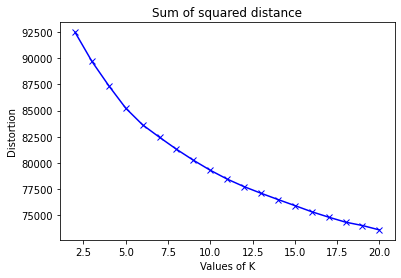

In [10]:
#Plot Elbow graph
plt.plot(axis, elbow, 'bx-') 
plt.title('Values of K') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('Sum of squared distance') 
plt.show() 

In [11]:
# Choose n_clusters using elbow method, if the dataset is small, silhouette graph could be used
KmeansModel = KMeans(n_clusters=11, random_state=0)
Preds=KmeansModel.fit_predict(together_reduced)

In [20]:
# Assign cluster numbers to each of the document in all datasets
cu_wells_vendor_label=Preds[0:n_cu]
mortgages_wells_vendor_label=Preds[n_cu:n_mortgages+n_cu]
banks_wells_vendor_label=Preds[n_mortgages+n_cu:n_mortgages+n_cu+n_banks]
wells_label=Preds[n_mortgages+n_cu+n_banks:]

In [21]:
# Extract the frequency and label for each clusters for the vendors and Wells Fargo dataset
label_vendor_cu,count_vendor_cu=np.unique(cu_wells_vendor_label,return_counts=True)
label_vendor_mortgages,count_vendor_mortgages=np.unique(mortgages_wells_vendor_label,return_counts=True)
label_vendor_banks,count_vendor_banks=np.unique(banks_wells_vendor_label,return_counts=True)
label_wells,count_wells=np.unique(wells_label,return_counts=True)

In [23]:
# Check laebels, avoid zero in cluster [if it is zero then the label of the cluster will not show up in that dataset.]
print(label_vendor_cu,label_vendor_mortgages,label_vendor_banks,label_wells)

[ 0  1  2  3  4  5  6  7  8  9 10] [0 1 2 3 4 5 6 7 8 9] [ 0  1  2  3  4  5  6  7  8  9 10] [ 0  1  2  3  4  5  6  7  8  9 10]


In [24]:
# Helper function normalize cluster frequency
# Normalize frequency to 100 and assign 0 to count if no document fall in one of the cluster

# k: number of clusters, int
# c_count:cluster counts, numpy array
# c_label:cluster labels, numpy arrary
# return: normalized count in each cluster, numpy array, shape=(k,)

def normalize(c_count,c_label, k):
  result=np.zeros(k)
  for i in range(len(c_label)):
    result[c_label[i]]=c_count[i]
  result=result/np.sum(result)*100
  return result

In [26]:
# Apply normalize function to all dataset
percent_cu=normalize(count_vendor_cu,label_vendor_cu,11)
percent_mortgages=normalize(count_vendor_mortgages,label_vendor_mortgages,11)
percent_banks=normalize(count_vendor_banks,label_vendor_banks,11)
percent_wells=normalize(count_wells,label_wells,11)

In [27]:
# Print normalized result
print(percent_cu)
print(percent_mortgages)
print(percent_banks)
print(percent_wells)

[16.45922986  1.57789402 18.79729602 18.76980957  2.93417854 12.38436365
  2.67649307  0.29547934  7.78553697  4.859089   13.46062996]
[ 5.98733955  0.14067171  1.21329348  1.80235625 11.30648848  0.56268683
 51.80235625  1.00228592  2.5496747  23.63284684  0.        ]
[ 3.14401797 26.96243979  2.60401488  2.82344471  9.0891948   2.15486946
 13.0183601  28.07158898  2.34515626  9.6617695   0.12514357]
[ 2.54852991  6.7658077   2.3725735   2.4123056  10.54603247  1.78794415
 37.57520717 22.60756045  2.38960154 10.83550914  0.15892837]


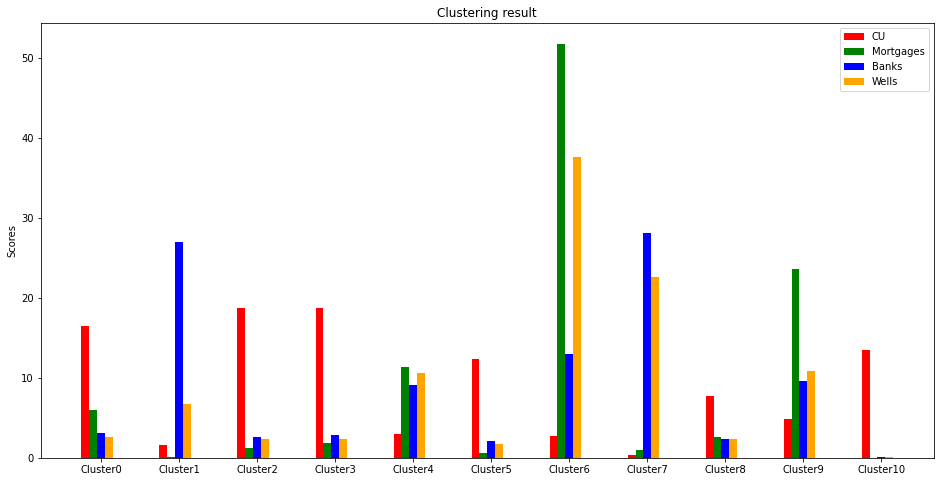

In [29]:
# Graph the cluster result
labels = ["Cluster0","Cluster1","Cluster2","Cluster3","Cluster4","Cluster5","Cluster6","Cluster7","Cluster8","Cluster9","Cluster10"]

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x -2*width, percent_cu, width, label='CU',color="red")
rects2 = ax.bar(x -width, percent_mortgages, width, label='Mortgages',color="green")
rects3 = ax.bar(x, percent_banks, width, label='Banks',color="blue")
rects4 = ax.bar(x +width, percent_wells, width, label='Wells',color="orange")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Clustering result')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [30]:
from scipy.stats import chisquare
print(chisquare(percent_cu,f_exp=percent_wells))
print(chisquare(percent_mortgages,f_exp=percent_wells))
print(chisquare(percent_banks,f_exp=percent_wells))

Power_divergenceResult(statistic=1556.0400765984089, pvalue=0.0)
Power_divergenceResult(statistic=54.06092463701522, pvalue=4.727111531470431e-08)
Power_divergenceResult(statistic=78.30196651906203, pvalue=1.079408564040599e-12)


Test other random seeds and cluster numbers

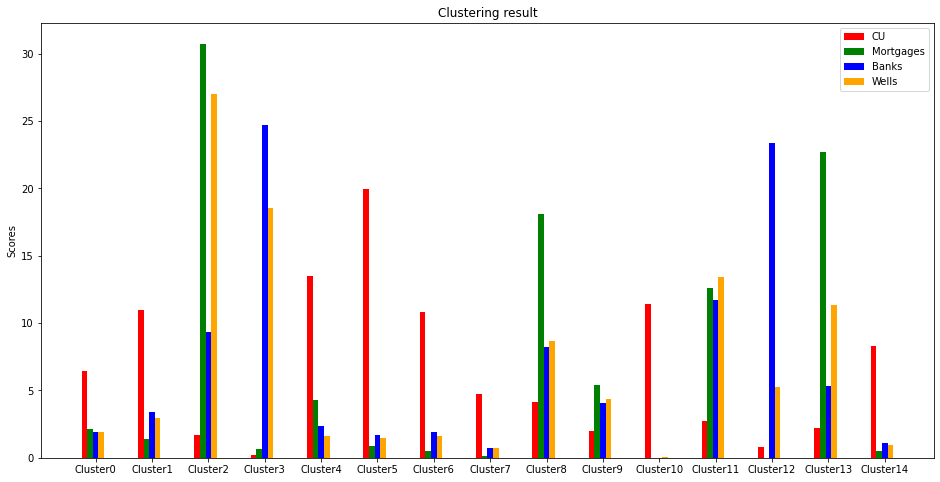

In [40]:
# Same code as above, allow customize of random see and clusters to test out different result
random_seed=5
num_clusters=15

KmeansModel = KMeans(n_clusters=num_clusters, random_state=random_seed)
Preds=KmeansModel.fit_predict(together_reduced)
# Assign cluster numbers to each of the document in all datasets
cu_wells_vendor_label=Preds[0:n_cu]
mortgages_wells_vendor_label=Preds[n_cu:n_mortgages+n_cu]
banks_wells_vendor_label=Preds[n_mortgages+n_cu:n_mortgages+n_cu+n_banks]
wells_label=Preds[n_mortgages+n_cu+n_banks:]
# Extract the frequency and label for each clusters for the vendors and Wells Fargo dataset
label_vendor_cu,count_vendor_cu=np.unique(cu_wells_vendor_label,return_counts=True)
label_vendor_mortgages,count_vendor_mortgages=np.unique(mortgages_wells_vendor_label,return_counts=True)
label_vendor_banks,count_vendor_banks=np.unique(banks_wells_vendor_label,return_counts=True)
label_wells,count_wells=np.unique(wells_label,return_counts=True)
percent_cu=normalize(count_vendor_cu,label_vendor_cu,num_clusters)
percent_mortgages=normalize(count_vendor_mortgages,label_vendor_mortgages,num_clusters)
percent_banks=normalize(count_vendor_banks,label_vendor_banks,num_clusters)
percent_wells=normalize(count_wells,label_wells,num_clusters)

# Graph the cluster result
# Compile bin tickers
labels=[]
for i in range(0,num_clusters):
  temp_string="Cluster"+str(i)
  labels.append(temp_string)

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x -2*width, percent_cu, width, label='CU',color="red")
rects2 = ax.bar(x -width, percent_mortgages, width, label='Mortgages',color="green")
rects3 = ax.bar(x, percent_banks, width, label='Banks',color="blue")
rects4 = ax.bar(x +width, percent_wells, width, label='Wells',color="orange")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Clustering result')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [41]:
from scipy.stats import chisquare
print(chisquare(percent_cu,f_exp=percent_wells))
print(chisquare(percent_mortgages,f_exp=percent_wells))
print(chisquare(percent_banks,f_exp=percent_wells))

Power_divergenceResult(statistic=3793.4975621204626, pvalue=0.0)
Power_divergenceResult(statistic=51.63880207590379, pvalue=3.2367015025611733e-06)
Power_divergenceResult(statistic=79.43046677073757, pvalue=3.60820815341486e-11)
